In [10]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
from scipy.stats import binned_statistic, binned_statistic_dd


In [11]:
counts_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/compute_metrics/results/PSD_counts'
plot_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/plots/RALSD'
final_figure_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/final_figures'


In [12]:
'''
RALSD
'''

def write_to_dict(result_dict,period,epoch,gcm,ml_type,framework,n,ralsd):
    
    result_dict['period'].append(period)
    result_dict['epoch'].append(epoch)
    result_dict['GCM'].append(gcm)
    result_dict['ml_type'].append(ml_type)
    result_dict['framework'].append(framework)
    result_dict['sample_n'].append(n)
    result_dict['ralsd'].append(ralsd)
    
    
def get_ralsd_df(start,end,metric,epochs):
    
    result_dict = {'GCM':[],'ml_type':[],'framework':[],'period':[],'sample_n':[],'ralsd':[],'epoch':[]}

    for epoch in epochs:
        for gcm in ['EC-Earth3','NorESM2-MM']:
            for ml_type in ['GAN','unet']:
                for framework in ['perfect','imperfect']:
            
                    df = pd.read_csv(f'{counts_dir}/{gcm}_{ml_type}_{framework}_epoch_{epoch}_{start}-{end}_{metric}_PSD_counts.csv').drop('Unnamed: 0',axis=1)

                    ccam_counts = df['CCAM']

                    for i,n in enumerate(['5','10','20','30','40','50','60','80','100','120','140','1961-1980','2015-2034','2080-2099']):#,'140'

                        ml_counts = df[n]
                        
                        log_diff = 10 * (np.log10(ml_counts) - np.log10(ccam_counts))
                        diff_rmse = np.sqrt(np.mean(log_diff ** 2))

                        write_to_dict(result_dict,f'{start}-{end}',epoch,gcm,ml_type,framework,n,diff_rmse)

    df = pd.DataFrame.from_dict(result_dict)
    
    return(df)


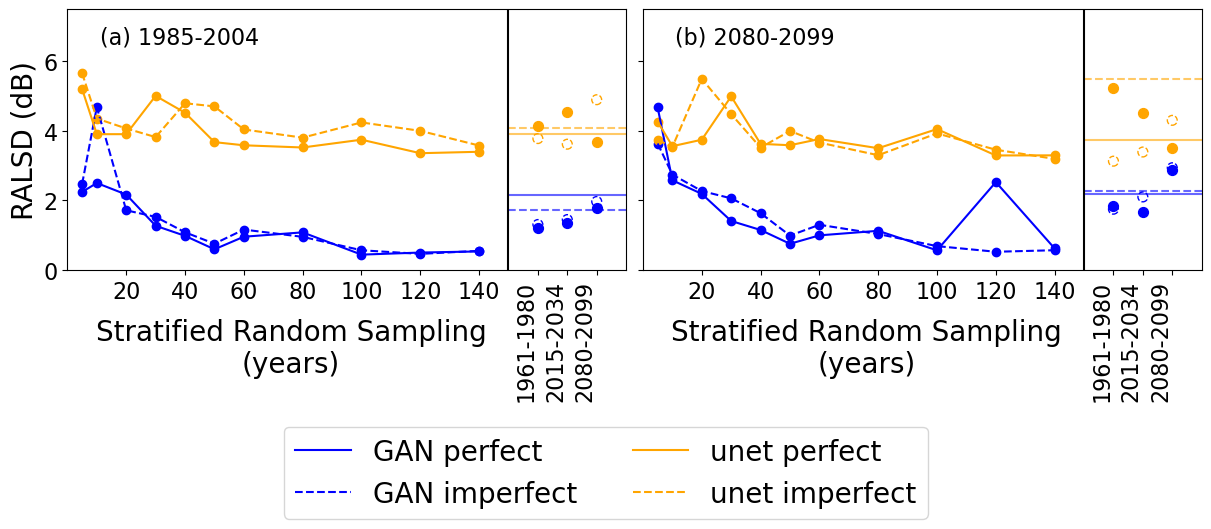

In [19]:
'''
2-GCM AND 3-epoch average
'''


metric = 'top_200'#'top_200'#'rx1d'#''

lims = {'rx1d':(0,11),'top_200':(0,7.5)}

colors = {'GAN':'blue','unet':'orange'}
capitalized = {'GAN':'GAN','unet':'Unet','rx1d':'Rx1d','annual_mean':'Annual Mean','DJF_mean':'DJF Mean','JJA_mean':'JJA Mean',\
               'perfect':'Perfect','imperfect':'Imperfect'}


epochs = ['220','225','230']
x_ticks = {'1961-1980':160,'2015-2034':170,'2080-2099':180}
subplot_labels = ['(a)','(b)']

low,high = lims[metric]

fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True,sharex=True,layout='constrained')

for i,period in enumerate([('1985','2004'),('2080','2099')]):

    start,end = period[0],period[1]
    
    df = get_ralsd_df(start,end,metric,epochs)

    for ml_type in ['GAN','unet']:

        ml_type_df = df[df['ml_type']==ml_type]

        for framework in ['perfect','imperfect']:

            framework_df = ml_type_df[ml_type_df['framework']==framework]

            gcm_dfs = []
            for gcm  in ['EC-Earth3','NorESM2-MM']:
                gcm_result = framework_df[framework_df['GCM']==gcm].groupby('sample_n').mean(numeric_only=True)['ralsd']
                gcm_dfs.append(gcm_result)

            mean = sum(gcm_dfs)/2

            results_n = mean[~mean.index.isin(['1961-1980','2015-2034','2080-2099'])]
            results_n.index = results_n.index.astype(int)
            results_n = results_n.sort_index()

            results_20 = mean[mean.index.isin(['1961-1980','2015-2034','2080-2099'])]

            # PLOTTING

            # dashed line at 20-year random sampling
            random_20_val = results_n[20]
            #axs[i].hlines(random_20_val,15,25,color=colors[ml_type],alpha=0.6,linestyle = '-' if framework=='perfect' else '--')
            axs[i].hlines(random_20_val,150,190,color=colors[ml_type],alpha=0.6,linestyle = '-' if framework=='perfect' else '--')

            # n samples
            x = [int(v) for v in results_n.index]
            axs[i].plot(x,results_n,color=colors[ml_type],linestyle = '-' if framework=='perfect' else '--',label=f'{ml_type} {framework}')
            axs[i].scatter(x,results_n,color=colors[ml_type])

            # 20-year samples
            for k,index in enumerate(results_20.index):
                x_val = x_ticks[index]
                axs[i].scatter(x_val,results_20.loc[index],s=50,facecolors='none' if framework == 'imperfect' else colors[ml_type],edgecolors=colors[ml_type],linestyle = '-' if framework=='perfect' else '--')

    axs[i].text(0.2,0.85,f'{subplot_labels[i]} {start}-{end}', transform=axs[i].transAxes,ha='center', va='bottom', fontsize=16)

    # AXIS LABELS
    axs[i].set_ylim(low,high)
    
    axs[i].text(0.4, -0.3, 'Stratified Random Sampling\n(years)', va='center', ha='center',rotation='horizontal', transform=axs[i].transAxes,fontsize=20)


    axs[i].axvline([150],color='black')
    axs[i].tick_params(axis='y', labelsize=16)
    axs[i].set_xlim(0,190)

    if i == 0:
        axs[i].set_ylabel('RALSD (dB)',fontsize=20)

    # configure xticks and labels
    positions = [20, 40, 60, 80, 100, 120, 140, 160, 170, 180]
    labels = ['20', '40', '60', '80', '100', '120', '140', '1961-1980', '2015-2034', '2080-2099']

    # Set all at once
    axs[i].set_xticks(positions)
    axs[i].set_xticklabels(labels, fontsize=16)

    # Rotate only the "future period" labels
    for pos, label in zip(positions, axs[i].get_xticklabels()):
        if pos >= 160:
            label.set_rotation(90)
            label.set_ha('right')


handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.32),fontsize=20)


epoch_string = '-'.join(epochs)

#plt.savefig(f'{plot_dir}/{metric}_epochs_{epoch_string}_2GCM_average.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,))

In [8]:
df

,GCM,ml_type,framework,period,sample_n,ralsd,epoch
0,EC-Earth3,GAN,perfect,2080-2099,5,NaN,220
1,EC-Earth3,GAN,perfect,2080-2099,10,NaN,220
2,EC-Earth3,GAN,perfect,2080-2099,20,NaN,220
3,EC-Earth3,GAN,perfect,2080-2099,60,NaN,220
4,EC-Earth3,GAN,perfect,2080-2099,100,NaN,220
...,...,...,...,...,...,...,...
211,NorESM2-MM,unet,imperfect,2080-2099,100,3.413349,230
212,NorESM2-MM,unet,imperfect,2080-2099,140,2.236805,230
213,NorESM2-MM,unet,imperfect,2080-2099,1961-1980,3.095107,230
214,NorESM2-MM,unet,imperfect,2080-2099,2015-2034,3.110913,230


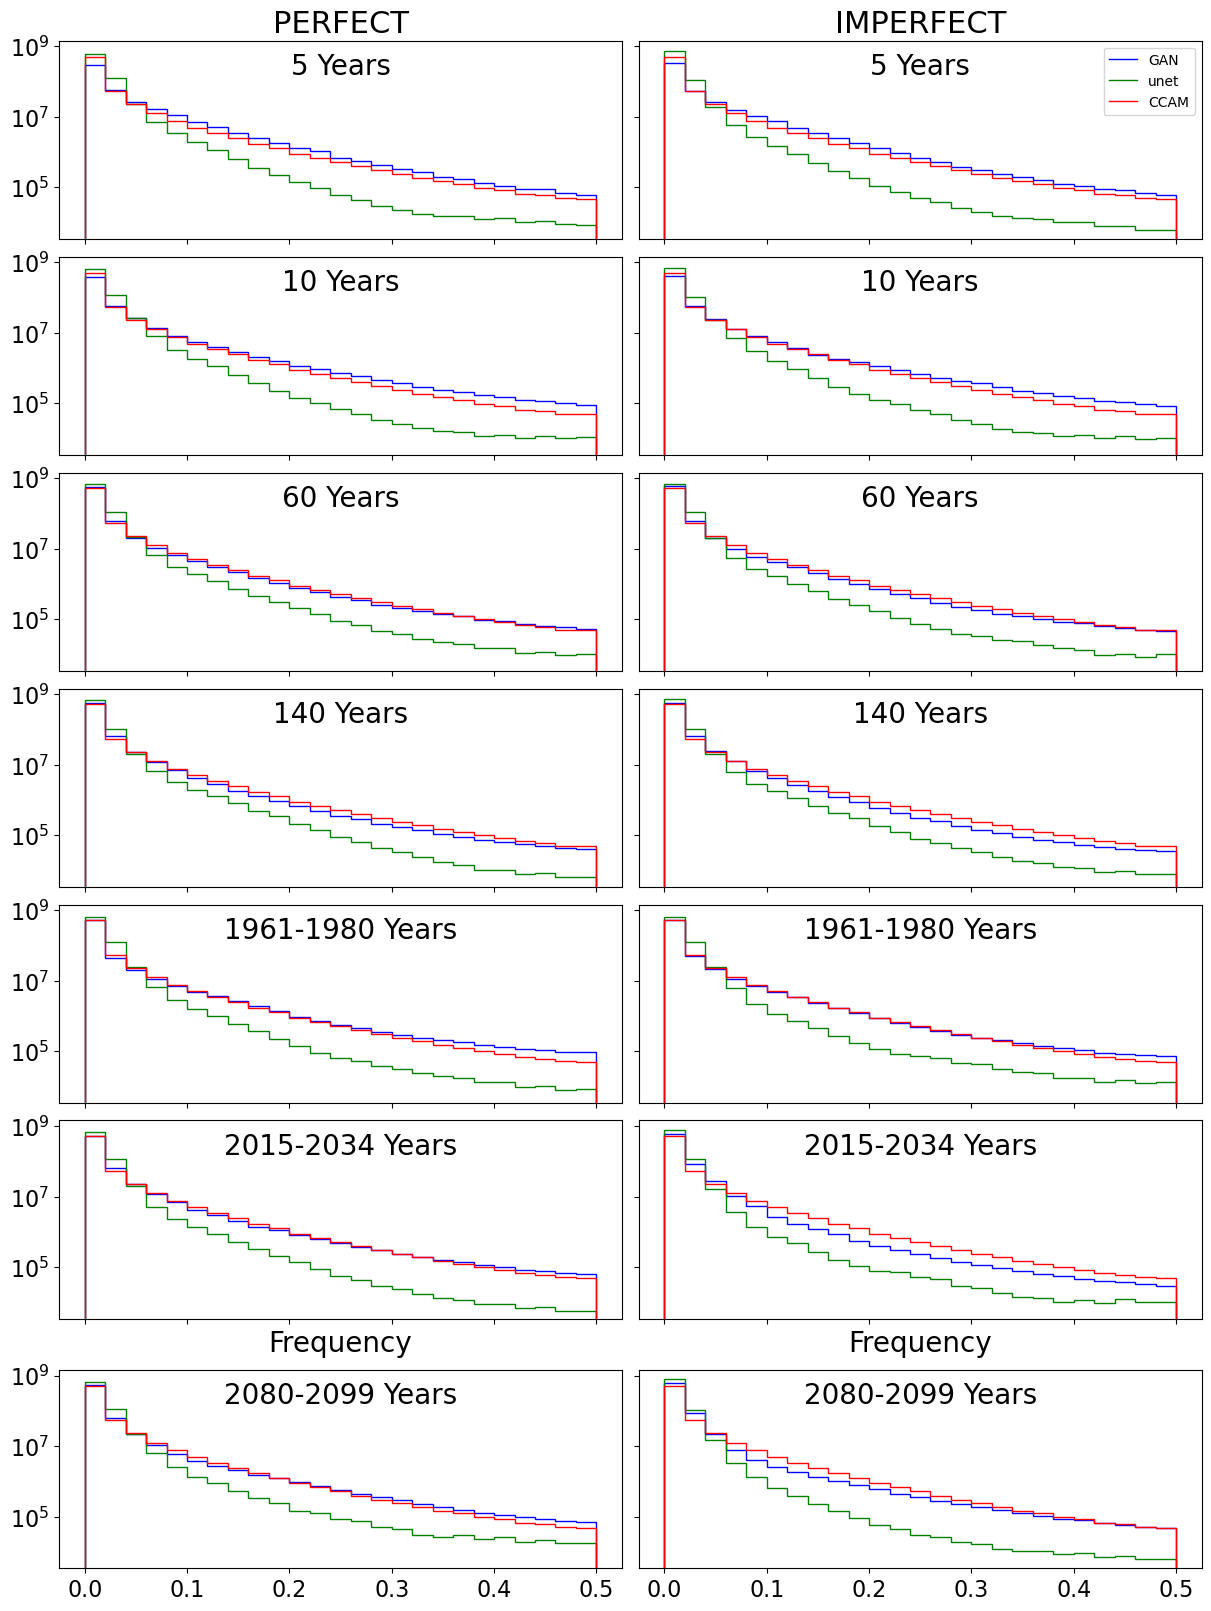

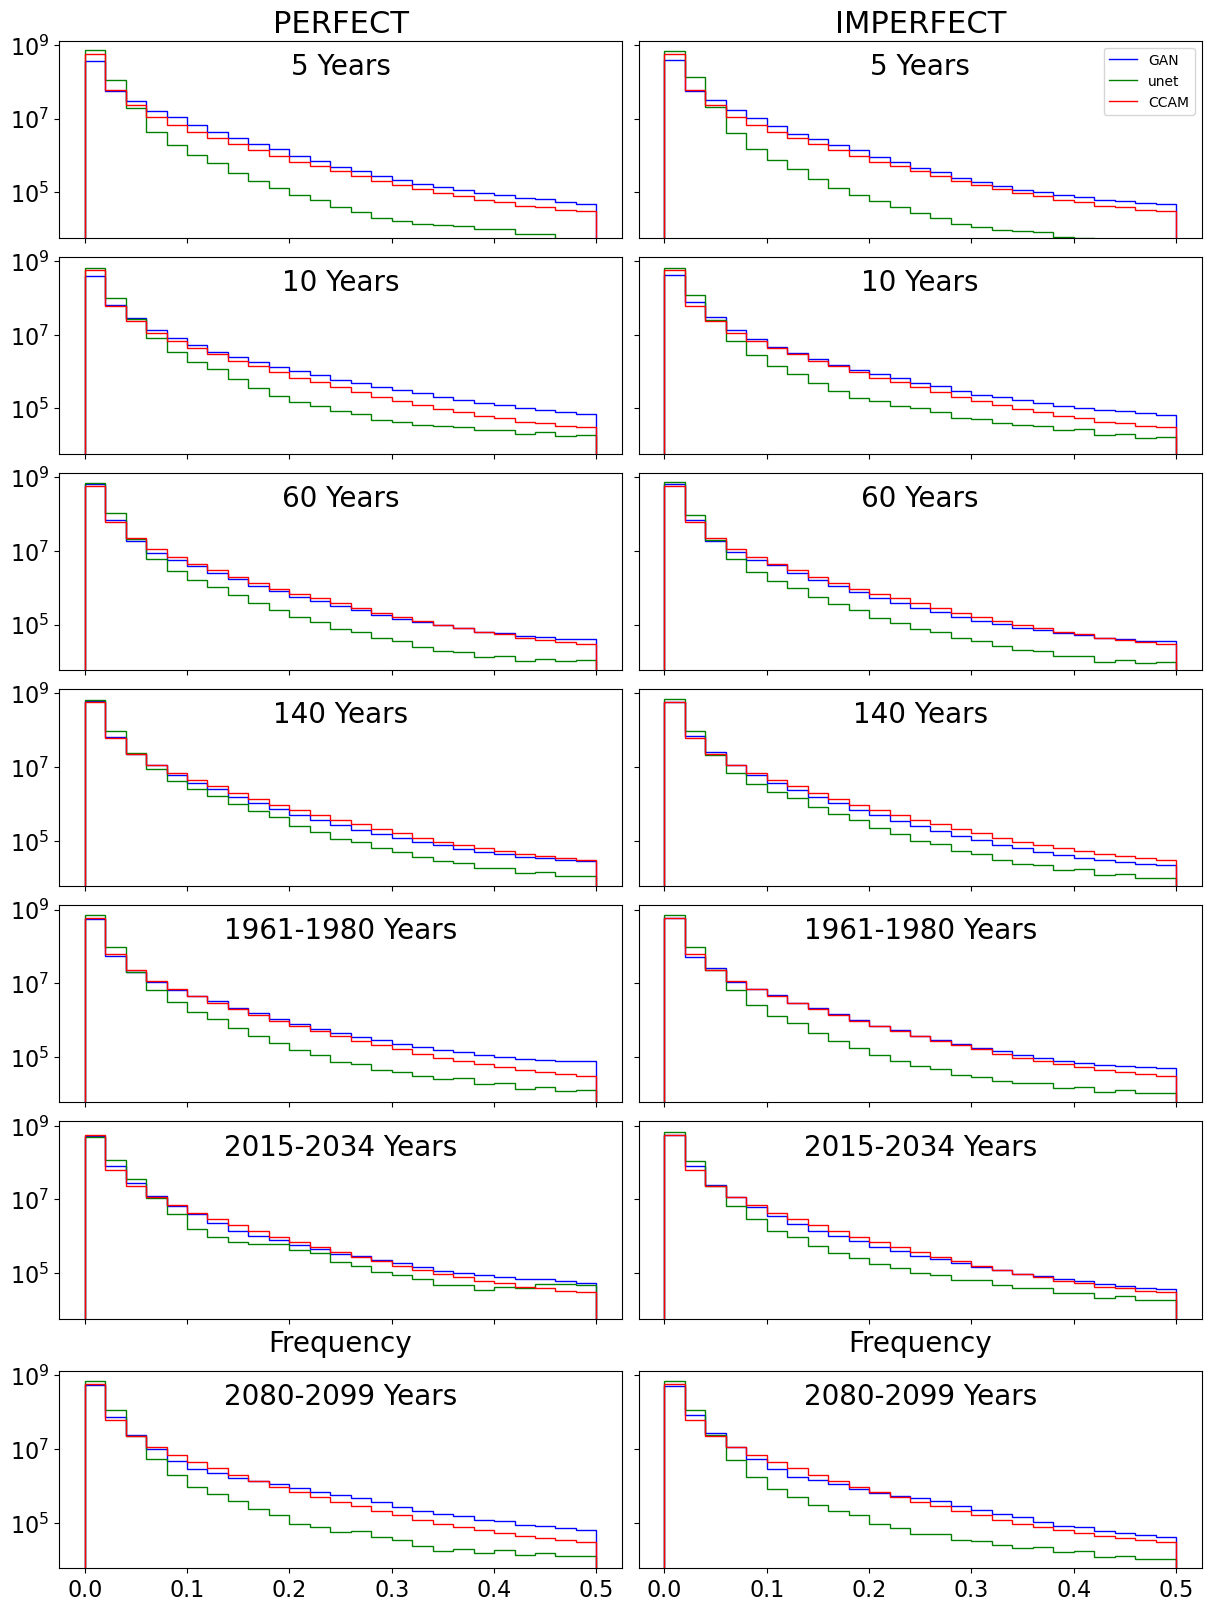

In [11]:
'''
Plot histograms 
'''


for gcm in ['EC-Earth3','NorESM2-MM']:

    for epoch in ['130']:

        #if os.path.exists(f'/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/histograms/{gcm}_epoch_{epoch}_{start}-{end}.png'):
        #    print('file exists, skipping')
        #    continue

        fig,axs = plt.subplots(7,2,figsize=(12,16),sharex=True,sharey=True,layout='constrained')

        for j,framework in enumerate(['perfect','imperfect']):

            gan_df = pd.read_csv(f'{result_dir}/{gcm}_GAN_{framework}_epoch_{epoch}_{start}-{end}_{metric}_PSD_counts.csv').drop('Unnamed: 0',axis=1)
            unet_df = pd.read_csv(f'{result_dir}/{gcm}_unet_{framework}_epoch_{epoch}_{start}-{end}_{metric}_PSD_counts.csv').drop('Unnamed: 0',axis=1)

            for i,n in enumerate(['5','10','60','140','1961-1980','2015-2034','2080-2099']):

                bins = gan_df['bin_left'].values.tolist() + [gan_df['bin_right'].values[-1]]

                gan_counts = gan_df[n]
                unet_counts = unet_df[n]
                ccam_counts = gan_df['CCAM']

                axs[i][j].stairs(gan_counts,bins,color='blue',label=f'GAN')
                axs[i][j].stairs(unet_counts,bins,color='green',label=f'unet')
                axs[i][j].stairs(ccam_counts,bins,color='red',label=f'CCAM')

                axs[i][j].set_yscale('log')

                axs[i][j].text(0.5,0.8,f'{n} Years', transform=axs[i][j].transAxes,ha='center', va='bottom', fontsize=20)

                axs[i][j].set_yscale('log')
                axs[i][j].tick_params(axis='y', labelsize=16)
                axs[i][j].tick_params(axis='x', labelsize=16)

                if i == 5:
                    axs[i][j].set_xlabel('Frequency',fontsize=20)

        axs[0][1].legend()
        axs[0][0].set_title('PERFECT',fontsize=22)
        axs[0][1].set_title('IMPERFECT',fontsize=22)



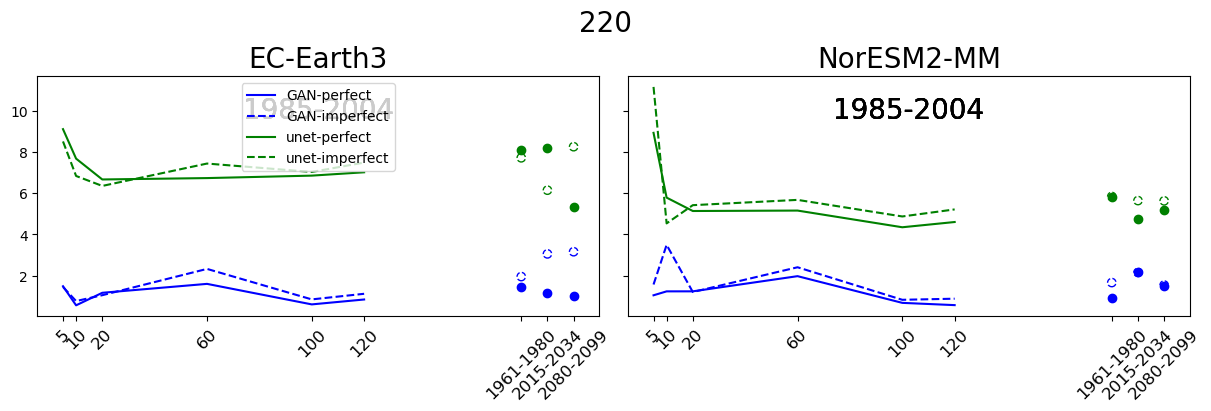

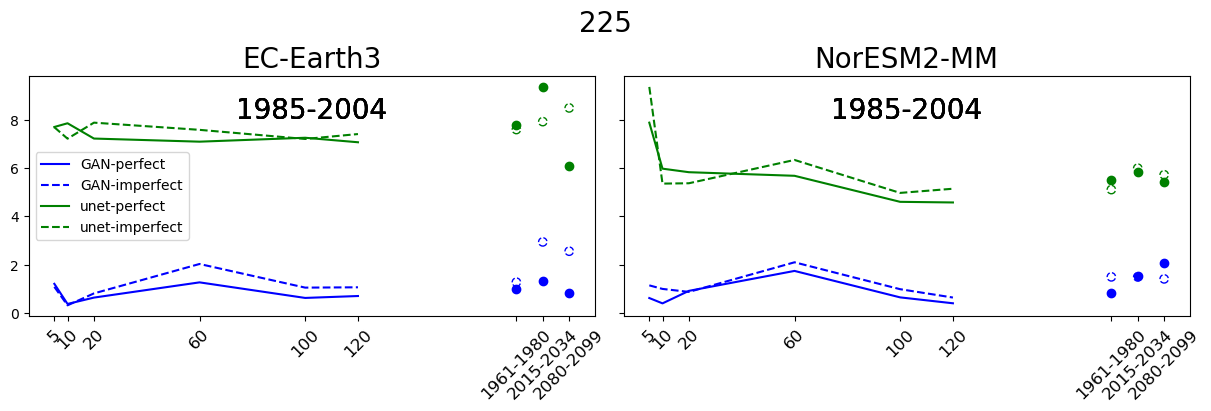

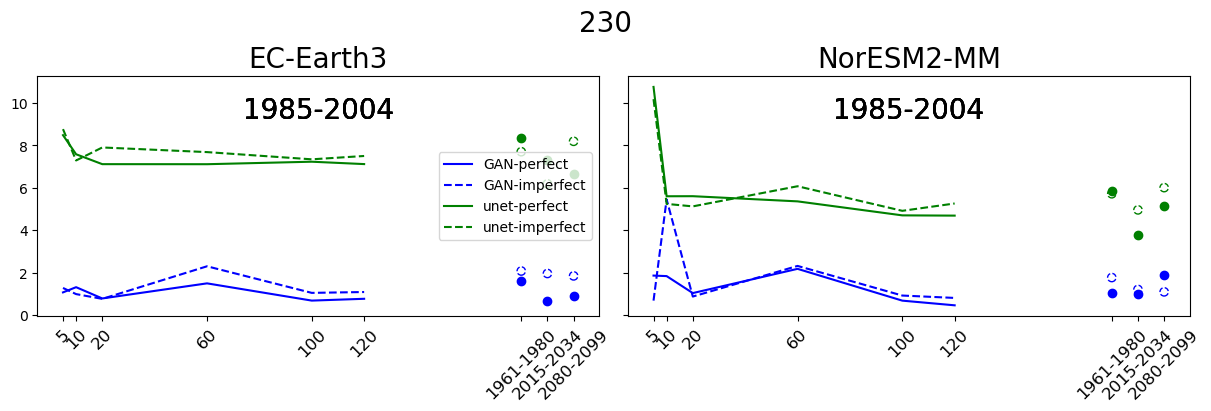

In [22]:
'''
Plot RALSD
'''

colors = {'GAN':'blue','unet':'green'}

start,end,metric = ('1985','2004','rx1d')

epochs = [220,225,230] 

df = get_ralsd_df(start,end,metric,epochs)
df_n = df[~df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
df_20 = df[df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]

for epoch in epochs:
    
    fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True,sharex=True,layout='constrained')

    for j,gcm in enumerate(['EC-Earth3','NorESM2-MM']):

        for ml_type in ['GAN','unet']:

            for framework in ['perfect','imperfect']:
                
                current_df = (df[(df['ml_type']==ml_type) & (df['framework']==framework) & (df['GCM']==gcm) & (df['epoch']==epoch)])
                
                # n-samplings
                df_n = current_df[~current_df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
                vals = df_n['ralsd']
                x_n = df_n['sample_n']
                
                axs[j].plot([int(v) for v in x_n],vals,color='blue' if ml_type == 'GAN' else 'green',linestyle = '-' if framework=='perfect' else '--',label=f'{ml_type}-{framework}')

                # 20-yr samplings
                df_20 = current_df[current_df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
                vals = df_20['ralsd']
                x_20 = df_20['sample_n']
                
                axs[j].scatter([180,190,200],vals,facecolors='none' if framework == 'imperfect' else colors[ml_type],edgecolors=colors[ml_type],linestyle = '-' if framework=='perfect' else '--')

                axs[j].set_xticks([int(v) for v in x_n] + [180,190,200],labels=x_n.values.tolist() + x_20.values.tolist(),fontsize=12,rotation=45)


                axs[j].set_title(gcm,fontsize=20)

                axs[j].text(0.5,0.8,f'{start}-{end}', transform=axs[j].transAxes,ha='center', va='bottom', fontsize=20)


    axs[0].legend()
    plt.suptitle(f'{epoch}',fontsize=20)

        

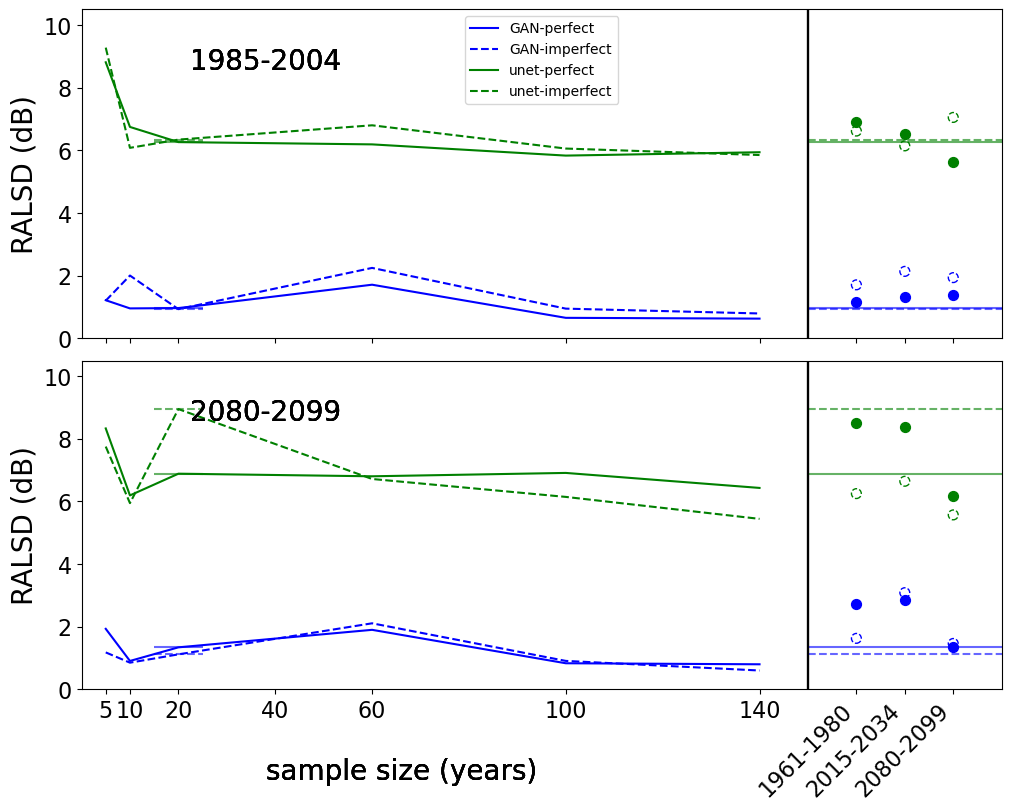

In [11]:
results_20

sample_n
1961-1980    6.250583
2015-2034    6.644794
2080-2099    5.570679
Name: ralsd, dtype: float64